In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from khajiit_common.intermediate_results_caching import Vault
from tqdm.auto import tqdm

In [2]:
import sys
import re
import torch
from torch import nn as nn
import random
import pytorch_transformers
import logging
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 2"
from path import Path
from pytorch_transformers import BertTokenizer, BertPreTrainedModel, BertModel
from pytorch_transformers.optimization import AdamW, WarmupLinearSchedule
from sklearn_pytorch.nlp import BertPreprocessor
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from torch.nn import BCELoss
from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss, RunningAverage, TopKCategoricalAccuracy
from ignite.contrib.handlers import ProgressBar, TensorboardLogger
from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler
from ignite.handlers import ModelCheckpoint, EarlyStopping

I1027 07:49:59.804848 139849168561984 modeling_bert.py:139] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
I1027 07:49:59.811052 139849168561984 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [3]:
HEADER_TEST = ['id', 'title', 'text']
HEADER_TRAIN = ['id', 'title', 'text', 'tags']
RANDOM_SEED = 442
TEST_SIZE = .1
EXPERIMENT_NAME = 'ya_champ_multiclass_full_data'

In [4]:
def set_random_seed(seed, cudnn_deterministic=False):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)
    if torch.cuda.device_count() > 0:
        torch.cuda.manual_seed_all(seed)

    if cudnn_deterministic:
        torch.backends.cudnn.deterministic = True
    else:
        torch.backends.cudnn.deterministic = False

In [5]:
def get_file_iterator(file):
    for line in file:
        yield line #.readline()

In [6]:
set_random_seed(RANDOM_SEED)

In [9]:
def get_data(path, col_no=4, header=HEADER_TRAIN):
    count = 0
    junk_rows = {k: [] for k in np.arange(col_no)}
    junk_row_numbers = {k: [] for k in np.arange(col_no)}
    train_data_clean = {k: [] for k in header}
    with open(path, encoding='utf-8') as src_file:
        f_iter = get_file_iterator(src_file)
        for i, line in enumerate(f_iter):
            count += 1
            row = line.replace('\n', '').split('\t')
            if len(row) >= col_no - 1:
                if len(row) == col_no:
                    for j, k in enumerate(header):
                        train_data_clean[k].append(row[j].strip())
                elif col_no == 3:
                    train_data_clean[header[0]].append(row[0])
                    train_data_clean[header[1]].append(' ')
                    train_data_clean[header[2]].append(row[-1].strip())
#                     else:
#                         train_data_clean[header[2]].append(row[-2])
#                         train_data_clean[header[3]].append(row[-1])
                    
    #         if count > 10:
    #             break
            else:
                junk_rows[len(row)].append(row)
                junk_row_numbers[len(row)].append(i)
    train_data_clean = pd.DataFrame.from_dict(train_data_clean)
    train_data_clean['concatted_text'] = train_data_clean[['title', 'text']].apply(lambda row: '. '.join([row['title'], row['text']]).strip(), axis=1)
    train_data_clean.loc[train_data_clean['concatted_text'].str.startswith('. '), 'concatted_text'] = train_data_clean.loc[train_data_clean['concatted_text'].str.startswith('. '), 'concatted_text'].str[2:]
    mlb = MultiLabelBinarizer()
    if col_no > 3:
        train_data_clean['tags'] = train_data_clean['tags'].apply(lambda x: [int(nmbr) for nmbr in x.split(',')])
        mlb.fit(train_data_clean['tags'])
        train_data_clean['tags_nat'] = train_data_clean['tags']
        train_data_clean['tags'] = [tag_list for tag_list in mlb.transform(train_data_clean['tags'])]
    return train_data_clean, mlb, junk_rows, junk_row_numbers

In [8]:
# train_data_clean, mlb = get_data()

In [65]:
test_clean, mlb, junk_rows, junk_row_numbers = get_data('data/test.tsv', 3, HEADER_TEST)

In [74]:
train_clean, mlb, junk_rows, junk_row_numbers = get_data('data/train.tsv', 4, HEADER_TRAIN)

In [13]:
test_clean.shape

(31513, 5)

In [14]:
test_clean.tail(1)

,id,title,text,concatted_text,s
31512,157560,Маленький котенок был замурован в стене,"Шесть месяцев назад, в середине лета в Калифор...",Маленький котенок был замурован в стене. Шесть...,маленький котенок был замурован в стене шесть ...


In [13]:
test_clean.head(1)

,id,title,text,concatted_text
0,126048,Стадии любовных отношений,"Почему некоторые отношения распадаются, а друг...",Стадии любовных отношений. Почему некоторые от...


In [11]:
def get_train_val_data(data, return_subsample=False):
    train, val = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_SEED)
    if return_subsample:
        train = train.sample(100, random_state=RANDOM_SEED).copy()
        val = val.sample(100, random_state=RANDOM_SEED).copy()
    y_train = np.vstack(train['tags'].values)
    y_val = np.vstack(val['tags'].values)
    return train, val, y_train, y_val

In [12]:
# train, val, y_train, y_val = get_train_val_data(train_data_clean, return_subsample=True)

train, val, y_train, y_val = get_train_val_data(train_clean)

In [13]:
vault = Vault('processed', 'intermediate_results')

In [16]:
# vault.test_clean = test_clean

In [17]:
test_clean = vault.test_clean

In [19]:
n_gpu = torch.cuda.device_count()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
pretrained_bert_dir = Path('/work/work/word_embeddings/for_torch/rubert_cased_L-12_H-768_A-12_v1/dump_path/') 

In [22]:
tokenizer = BertTokenizer.from_pretrained(pretrained_bert_dir,
                                          do_lower_case=False)

I1027 04:47:19.136106 140718398465856 tokenization_utils.py:301] Model name '/work/work/word_embeddings/for_torch/rubert_cased_L-12_H-768_A-12_v1/dump_path/' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc). Assuming '/work/work/word_embeddings/for_torch/rubert_cased_L-12_H-768_A-12_v1/dump_path/' is a path or url to a directory containing tokenizer files.
I1027 04:47:19.138355 140718398465856 tokenization_utils.py:330] Didn't find file /work/work/word_embeddings/for_torch/rubert_cased_L-12_H-768_A-12_v1/dump_path/added_tokens.json. We won't load it.
I1027 04:47:19.139838 140718398465856 tokenization_utils.p

In [23]:
bert_preprocessor = BertPreprocessor(tokenizer)

In [24]:
# test = test_clean.sample(100).copy()

In [25]:
test = test_clean.copy()

In [21]:
test_features = bert_preprocessor.transform(test['concatted_text'])

In [56]:
val_features = bert_preprocessor.transform(val['concatted_text'])

In [57]:
def get_test_tensor_dataset(features, target_column=None):
    all_input_ids = torch.tensor(features['input_ids'], dtype=torch.long)
    all_token_type_ids = torch.tensor(features['token_type_ids'], dtype=torch.long)
    all_attention_mask = torch.tensor(features['attention_mask'], dtype=torch.long)
    
    return TensorDataset(all_input_ids, all_token_type_ids, all_attention_mask)

In [23]:
test_dataset = get_test_tensor_dataset(test_features)

In [58]:
val_dataset = get_test_tensor_dataset(val_features)

In [24]:
# vault.test_data_sigmoid = test_dataset


In [60]:
# vault.val_data_sigmoid = val_dataset


In [27]:
test_dataset = vault.test_data_sigmoid

In [28]:
val_dataset = vault.val_data_sigmoid

In [29]:
test_batch_size = 256

In [30]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

In [61]:
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=test_batch_size)

In [32]:
class BertForMCSequenceClassification(BertPreTrainedModel):
    r"""
        **labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for computing the sequence classification/regression loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.
            If ``config.num_labels == 1`` a regression loss is computed (Mean-Square loss),
            If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy).
    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Classification (or regression if config.num_labels==1) loss.
        **logits**: ``torch.FloatTensor`` of shape ``(batch_size, config.num_labels)``
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.
    Examples::
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute")).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, logits = outputs[:2]
    """
    def __init__(self, config):
        super(BertForMCSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)

        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, labels=None):

        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids, 
                            head_mask=head_mask)

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
#             loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            loss = loss_fct(logits, labels)
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [33]:
# train_clean, mlb, junk_rows, junk_row_numbers = get_data('data/train.tsv', 4, HEADER_TRAIN)

In [34]:
try:
    mlb
except NameError:
    mlb = None   

num_labels = len(mlb.classes_) if mlb else 100

In [35]:
model = BertForMCSequenceClassification.from_pretrained(pretrained_bert_dir,
                                                      num_labels=num_labels,
                                                      output_attentions=False)

I1027 04:47:49.262165 140718398465856 configuration_utils.py:146] loading configuration file /work/work/word_embeddings/for_torch/rubert_cased_L-12_H-768_A-12_v1/dump_path/config.json
I1027 04:47:49.264919 140718398465856 configuration_utils.py:166] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 100,
  "output_attentions": false,
  "output_hidden_states": false,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 119547
}

I1027 04:47:49.266626 140718398465856 modeling_

In [36]:
model.load_state_dict(torch.load(f'saved_models/{EXPERIMENT_NAME}/bert_classifier_model_state_dict_3_val_loss=0.04258026.pth'))

<All keys matched successfully>

In [37]:
model = model.to(device)

if n_gpu > 1:
    model = torch.nn.DataParallel(model)

In [38]:
def get_proba(dataloader):
    sigmoid = torch.nn.Sigmoid()
    result = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, token_type_ids, attention_mask = (t.to(device) for t in batch)
            model_output = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
            logits = model_output[0]
            predicted_proba = sigmoid(logits)
#             preds = torch.argmax(predicted_proba, 1)
            result.append(predicted_proba.to('cpu').numpy())
    return np.concatenate(result, axis=0)

In [39]:
test_preds = get_proba(test_dataloader)

In [62]:
val_preds = get_proba(val_dataloader)

In [64]:
# vault.test_preds_full_text = test_preds
# vault.val_preds_full_text = val_preds

In [61]:
test_preds = vault.test_preds_full_text
# vault.val_preds_full_text = val_preds

In [129]:
def get_taglist_upd(preds, mlb):
    coef = .65
    pred_tags = mlb.inverse_transform(preds.round())
    empty_ix = [i for i in range(len(pred_tags)) if len(pred_tags[i]) == 0]
    non_empty_ix = [i for i in range(len(pred_tags)) if len(pred_tags[i]) != 0]
    maxs = pd.Series(preds.max(axis=1) * coef).iloc[empty_ix]
    maxs_nemp = coef * .5
    for ix in empty_ix:
        pred_tags[ix] = (np.argmax(preds[ix]),)
    pred_tags_str = [str(list(tag_list))[1:-1] for tag_list in pred_tags]
    for i, iten in enumerate(empty_ix):
        pred_tags_str[iten] = str(list(np.where(preds[iten] >= maxs.iloc[i])[0]))[1:-1].replace(' ', '')
    for i, iten in enumerate(non_empty_ix):
        pred_tags_str[iten] = str(list(np.where(preds[iten] >= maxs_nemp)[0]))[1:-1].replace(' ', '')
    return pred_tags_str, pred_tags

In [130]:
test_str, test = get_taglist_upd(test_preds, mlb)

In [131]:
submission = pd.DataFrame({'ix': test_clean['id'], 'pred': test_str})

In [132]:
submission.sample(10)

,ix,pred
21386,147434,"57,77"
13051,139099,"2,29"
29014,155062,"0,4"
2896,128944,"11,15,41,65"
21275,147323,"14,81"
16335,142383,"9,71"
15026,141074,48
29678,155726,"18,53,69"
17739,143787,"12,21,30"
31102,157150,"8,14"


In [128]:
submission.to_csv('data/submission.tsv', sep='\t', header=False, index=False)

In [27]:
val[['concatted_text', 'tags_nat', 'pred_tags_nat']].sample(20)

,concatted_text,tags_nat,pred_tags_nat
112929,Грабителей подвела чистоплотность. Они не усто...,"[24, 27, 30]","(29,)"
63490,Каждому человеку просто необходимо быть поближ...,"[11, 47, 84]","(84,)"
55405,"Гипертония: симптомы, степени, лечение и профи...","[5, 43]","(5, 43)"
858,Mauser M2: удобный и надежный. Пистолет Mauser...,[76],"(76,)"
84139,"🍴 Кухонный фартук из ламината: идеи, технологи...","[44, 45]","(44, 45, 86)"
97256,Как завоевать женщину: секреты Антона Павлович...,"[2, 10]","(1,)"
84267,Интерьер квартиры в ЖК Европейский 80 м^2. Дан...,"[19, 20]","(44,)"
111770,"""Договориться на берегу"". Я думаю, что самая б...",[60],"(60, 72)"
95850,Ржака на ночь глядя: прикольный комикс про сит...,"[15, 21]","(21,)"
111704,Reebok #нивкакиерамки. 7 февраля отделение бр...,[6],"(20,)"


In [16]:
test = np.round(val_preds)

In [25]:
pd.Series(test.sum(axis=1)).value_counts()

1.0    7236
2.0    3309
0.0    1502
3.0     476
4.0      64
5.0       7
dtype: int64

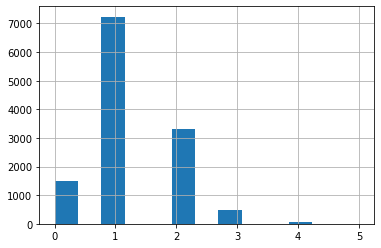

In [24]:
pd.Series(test.sum(axis=1)).hist(bins=13);

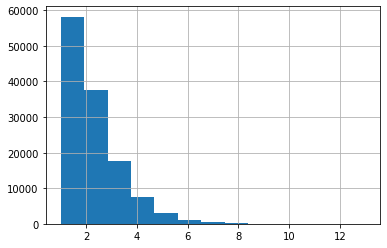

In [247]:
test.hist(bins=13);